# Does the Palmer Station (PSA) -- South Pole (SPO) CO$_2$ difference provide metric of fluxes?

In [2]:
%matplotlib inline
from config_calc import *
import grid_tools

from datetime import datetime
import xarray as xr
import numpy as np

import cftime

import dask
import dask.distributed

import ncar_jobqueue

import cesm_orcas_sci as cesm
import xcalendar as xcal

import esmlab

import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
cluster = ncar_jobqueue.NCARCluster(cores=18,
                                    processes=18)
client = dask.distributed.Client(cluster)
n_workers = 18 * 2
cluster.scale(n_workers)

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/distributed/deploy/local.py:106: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [4]:
!qstat | grep dask-worker

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'


In [5]:
client

Client Scheduler: tcp://10.148.13.191:36426 Dashboard: http://10.148.13.191/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read CESM dataset

In [6]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'
tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = ['CO2_OCN', 'O2_OCN']

ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v])

ds = cesm.convert_dataset(ds,case)
ds.CO2_OCN.attrs['long_name'] = 'CESM'
ds

<xarray.Dataset>
Dimensions:    (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 3347)
Coordinates:
  * ilev       (ilev) float64 1.651 2.085 2.62 3.276 ... 955.0 970.0 985.0 1e+03
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * slat       (slat) float64 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon       (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * time       (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    CO2_OCN    (time, lev, lat, lon) float32 dask.array<shape=(3347, 56, 192, 288), chunksize=(5, 56, 192, 288)>
    P0         float64 1e+05
    ch4vmr     (time) float64 dask.array<shape=(3347,), chunksize=(5,)>
    co2vmr     (time) float64 dask.array<shape=(3347,), ch

## Define station coordinates and interpolate

In [7]:
lon_lat = {'psa': [295.95, -64.7667],
           'spo': [0, -90.],
           'dp' : [295.31, -59.]}


stn = xr.Dataset()
stn['station'] = xr.DataArray(['psa', 'spo', 'dp'], dims=('station'), name='station')
stn['lat'] = xr.DataArray([lon_lat[s][-1] for s in stn.station.values], dims=('station'), name='lat')
stn['lon'] = xr.DataArray([lon_lat[s][0] for s in stn.station.values], dims=('station'), name='lon')
stn

<xarray.Dataset>
Dimensions:  (station: 3)
Coordinates:
  * station  (station) object 'psa' 'spo' 'dp'
Data variables:
    lat      (station) float64 -64.77 -90.0 -59.0
    lon      (station) float64 295.9 0.0 295.3

Do the interpolation

In [8]:
dss = (ds.isel(lev=-1).interp(lat=stn.lat, lon=stn.lon)
       .drop([v for v in ds.variables if v not in ['O2_OCN', 'CO2_OCN', 'time', 'time_bnds']]))
dss = dss.compute()
dss


<xarray.Dataset>
Dimensions:    (nbnd: 2, station: 3, time: 3347)
Coordinates:
  * time       (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
  * station    (station) object 'psa' 'spo' 'dp'
Dimensions without coordinates: nbnd
Data variables:
    CO2_OCN    (time, station) float64 -1.39 -0.7555 -0.7693 ... -9.004 -8.985
    time_bnds  (time, nbnd) float64 729.0 730.0 730.0 ... 4.075e+03 4.076e+03
    O2_OCN     (time, station) float64 62.93 39.21 53.14 ... 107.8 98.24 107.4

Compute station difference

In [9]:
psa_m_spo = (dss.sel(station='psa') - dss.sel(station='spo')).compute()
psa_m_spo

<xarray.Dataset>
Dimensions:    (nbnd: 2, time: 3347)
Coordinates:
  * time       (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    CO2_OCN    (time) float64 -0.6348 -0.3619 -0.185 ... -0.8929 -0.677 -0.9098
    time_bnds  (time, nbnd) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    O2_OCN     (time) float64 23.72 13.65 10.53 18.82 ... 11.34 7.937 9.521

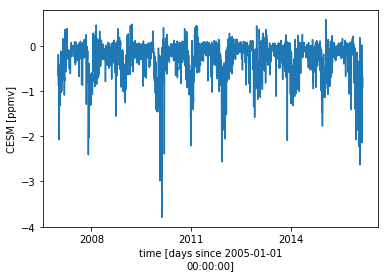

In [10]:
psa_m_spo.CO2_OCN.plot()

## Compute regional mean fluxes

In [11]:
grid = xr.open_dataset('./data/f09_f09.nc')
landfrac = grid.LANDFRAC.isel(time=0)

Re = 6.37122e6 # radius of earth [m]
area_earth = 4.0 * np.pi * Re**2 # area of earth (m^2)

# normalize area so that sum over 'lat', 'lon' yields area_earth
area = ds['gw'] + 0.0 * ds['lon'] # add 'lon' dimension
area = (area_earth / area.sum(dim=('lat', 'lon'))) * area
area.attrs['units'] = 'm2'

Define region masks

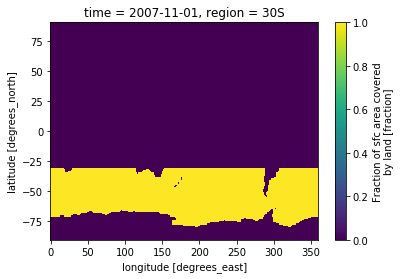

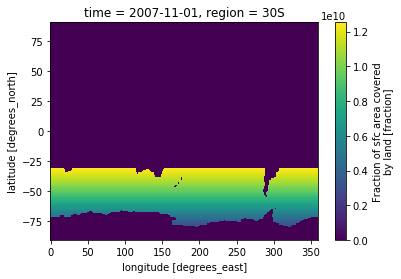

In [12]:
N = [-30, -35, -40, -44, -50, -55, -60]
region = xr.DataArray([f'{np.abs(n)}S' for n in N], dims=('region'), name='region')
for i, n in enumerate(N):
    rmask = (landfrac.where(landfrac<0.9)
             .fillna(0.).where(landfrac>=0.9)
             .fillna(1.).where(landfrac.lat<n).fillna(0.))
    if i == 0:
        RMASK = rmask
    else:
        RMASK = xr.concat((RMASK, rmask), dim='region')

RMASK['region'] = region
plt.figure()
RMASK.isel(region=0).plot()

wgt = RMASK * area
plt.figure()
wgt.isel(region=0).plot()


In [13]:
molyr_to_PgCyr = 12e-15
soflux = xr.Dataset()
soflux['CO2'] = esmlab.statistics.weighted_sum(ds.SFCO2_OCN, weights=wgt, dim=('lat', 'lon')).compute()
soflux['CO2'] = soflux.CO2 * molyr_to_PgCyr
soflux[ds.time.bounds] = ds[ds.time.bounds]
soflux.CO2.attrs['long_name'] = 'Air-sea flux'
soflux.CO2.attrs['units'] = 'PgC yr$^{-1}$'
soflux

<xarray.Dataset>
Dimensions:    (nbnd: 2, region: 7, time: 3347)
Coordinates:
  * time       (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
  * region     (region) <U3 '30S' '35S' '40S' '44S' '50S' '55S' '60S'
Dimensions without coordinates: nbnd
Data variables:
    CO2        (time, region) float64 -0.929 -1.046 -1.113 ... -0.04175 -0.3133
    time_bnds  (time, nbnd) float64 dask.array<shape=(3347, 2), chunksize=(5, 2)>

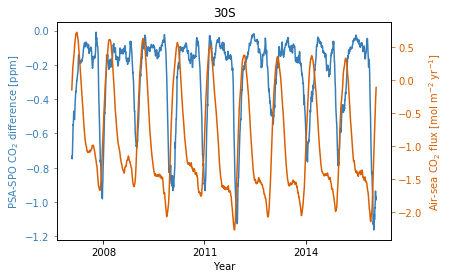

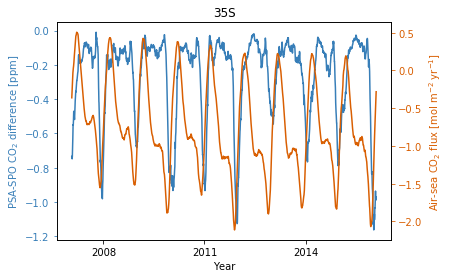

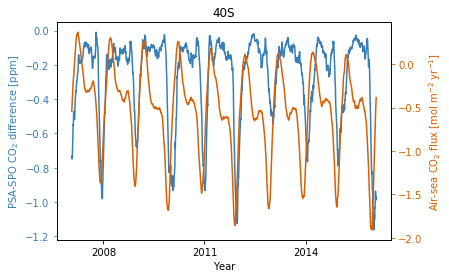

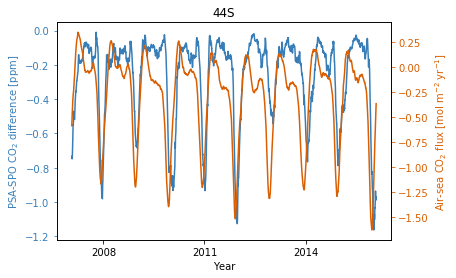

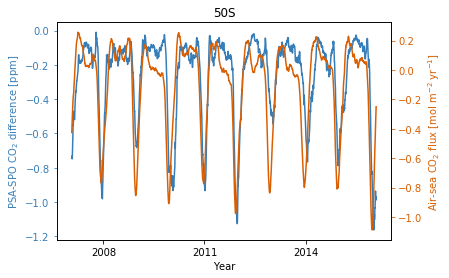

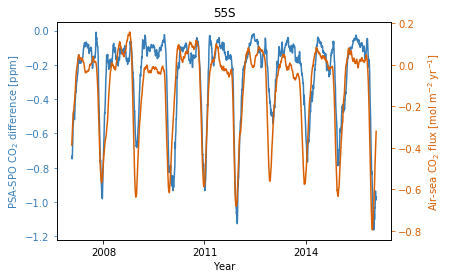

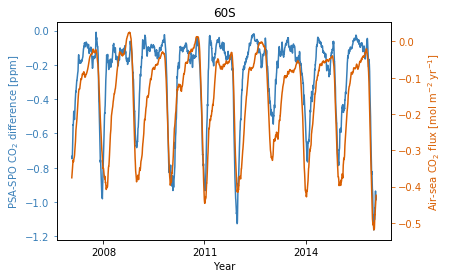

In [14]:

for r in region.values:
    fig = plt.figure() #figsize=[8, 5.3333])
    ax = fig.add_subplot(111)
    ax.plot(psa_m_spo.time, psa_m_spo.CO2_OCN.rolling(time=45, center=True).mean(),'-', color='#377eb8')
    ax.tick_params('y', colors='#377eb8')
    ax.set_ylabel('PSA-SPO CO$_2$ difference [ppm]', color='#377eb8')
    ax.set_xlabel('Year')
    ax.set_title(r)
    
    axR = ax.twinx()
    plt.plot(psa_m_spo.time, soflux.CO2.sel(region=r).rolling(time=45, center=True).mean(), color='#d95f02')
    axR.tick_params('y', colors='#d95f02')
    axR.set_ylabel('Air-sea CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]', color='#d95f02')

    plt.savefig(f'{diro["fig"]}/psa-spo-diff-cesm-{r}.png', bbox_inches='tight', dpi=300)

45, 45: 0.681024801896789
[-0.14999771  0.38948691]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     2855.
Date:                Tue, 23 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:21:41   Log-Likelihood:                 954.47
No. Observations:                3303   AIC:                            -1905.
Df Residuals:                    3301   BIC:                            -1893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


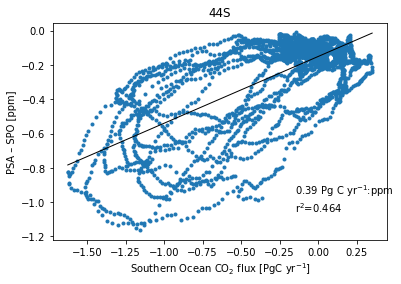

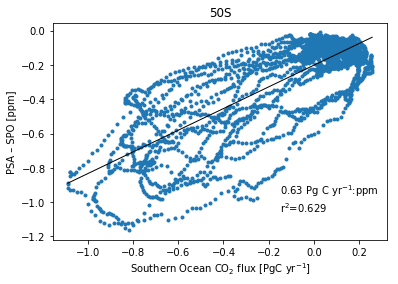

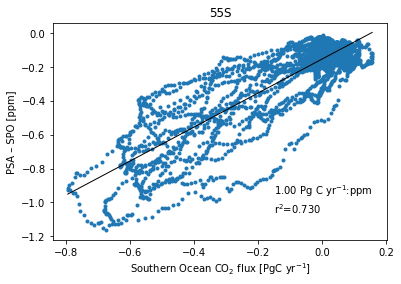

In [15]:
import statsmodels.api as sm
from scipy import stats
for n in ['44S', '50S', '55S']:
    for stn_lag in [45]:
        for flux_lag in [45]:

            y = psa_m_spo.CO2_OCN.rolling(time=stn_lag, center=True).mean()
            x = soflux.CO2.sel(region=n).rolling(time=flux_lag, center=True).mean()

            k = ~np.isnan(x) & ~np.isnan(y)
            R = np.corrcoef(x[k], y[k])[0, 1]
            print(f'{stn_lag}, {flux_lag}: {R}')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y, '.')
    
    k = ~np.isnan(x) & ~np.isnan(y)
    model = sm.OLS(y.values[k], sm.add_constant(x.values[k]))
    fitted = model.fit()

    print(fitted.params)
    print(fitted.summary())
    
    xhat = np.linspace(x.min(),x.max(),50)
    yhat = fitted.predict(sm.add_constant(xhat))
    ax.plot(xhat, yhat,'-',linewidth=1, color='k',zorder=10) 
    
    ax.text(-0.15, -1.05,'{0:0.2f} Pg C yr$^{{-1}}$:ppm\nr$^2$={1:0.3f}'.format(fitted.params[1],fitted.rsquared))

    ax.set_xlabel('Southern Ocean CO$_2$ flux [PgC yr$^{-1}$]')
    ax.set_ylabel('PSA – SPO [ppm]')
    ax.set_title(n)
    
    plt.savefig(f'{diro["fig"]}/psa-spo-v-flux-cesm-{n}.png', bbox_inches='tight', dpi=300)

In [16]:
soflux.time_bnds

<xarray.DataArray 'time_bnds' (time: 3347, nbnd: 2)>
dask.array<shape=(3347, 2), dtype=float64, chunksize=(5, 2)>
Coordinates:
  * time     (time) object 2006-12-31 12:00:00 ... 2016-02-28 12:00:00
Dimensions without coordinates: nbnd
Attributes:
    long_name:  time interval endpoints

In [17]:
soflux.CO2.plot()
soflux.CO2.rolling(time=30, center=True).mean().plot()

TypeError: Plotting requires coordinates to be numeric or dates of type np.datetime64, datetime.datetime, cftime.datetime or pd.Interval.